# Machine Learning in Network Science
Group Challenge

***
by: Leonardo Basili, Paul Bédier, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

This notebook covers deep learning techniques, namely:
- Variational Graph Normalized Auto-Encoders (based on https://arxiv.org/abs/2108.08046) which allow us to learn graph embeddings in an unsupervised way (based on graph structure and node embeddings)

### 1. Import Packages

In [33]:
from importlib import reload
reload(analyseData)
reload(prepData)
reload(loadData)
reload(modeling)
reload(autoenc)

<module 'util.autoencoder' from 'D:\\Dokumente\\2_Bildung\\2_MSc\\1_Classes\\Y2T2_Machine Learning in Network Science\\3_challenge\\Network-Science_Challenge\\util\\autoencoder.py'>

In [1]:
# import own scripts
import util.analyse_Data as analyseData
import util.preprocess_Data as prepData
import util.load_Data as loadData
import util.modeling as modeling
import util.autoencoder as autoenc

In [2]:
# parse & handle data
import os
import numpy as np
import pandas as pd

# modeling
import torch
from torch_geometric.nn import GAE, VGAE

# hyperparam optimization
from ray import tune, air

# evaluation
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data for Modeling

In [4]:
# might take up to a minute
data, (G, G_train, node_info, train_tf, val_tf, trainval_tf, test, test_tf) = autoenc.load(testing_ratio = 0.2)

Number of positive edges for training: 4174
Number of positive edges for validation: 1043
Number of edges in original graph: 5217
Number of edges in training graph: 4174
The graph is connected


In [5]:
# where to save trial results to
ray_path = os.path.abspath("")+"\\ray_results\\"
if not os.path.isdir(ray_path):
    os.mkdir(ray_path)

### 3. VGNAE Node Embeddings

https://github.com/SeongJinAhn/VGNAE/blob/main/main.py for Variational Graph Normalized Auto-Encoders

#### 3.1 Hyperparameter tuning

In [6]:
# tunable hyperparameter search space --> search using tune.choice([]), tune.uniform(lower, upper), tune.grid_search([])
config = {
    # log params in raytune
    "ray": True,
    
    # print results per epoch
    "verbose": False,
    
    # basic infos
    "data": data,
    "max_epochs": 300,
    "save": True, # if we want to save best model on validation set
    
    # model
    "model": "VGNAE",
    
    ## encoder
    "enc_channels": 64, # tune.grid_search([2, 8, 16, 64, 128])
    "scaling": tune.grid_search([1.2, 1.5, 1.8]), # tune.grid_search([0.2, 0.5, 1.5, 2])
    "num_prop": 5, # tune.grid_search([1, 2, 5])
    "teleport": tune.grid_search([0, 0.01, 0.05, 0.1, 0.2]), # tune.grid_search([0, 0.01, 0.05])
    "dropout": tune.grid_search([0, 0.01, 0.05, 0.1, 0.2]), # tune.grid_search([0, 0.01, 0.05])
    
    # optimizer
    "lr": 1e-5,
    "wd": 1e-1
}

In [7]:
# how many trials to run (if grid_search utilized, it will run this number per grid_search value)
num_samples = 1

# run experiment
result_grid = autoenc.run_ray_experiment(
    autoenc.train_validate, config, ray_path, num_samples,
    metric_columns = ["trn_acc", "val_acc", "max_val_acc", "training_iteration"],
    parameter_columns = ["enc_channels", "scaling", "num_prop", "teleport", "dropout", "lr", "wd"]
)

2023-03-12 19:41:41,513	INFO worker.py:1553 -- Started a local Ray instance.
2023-03-12 20:11:37,803	INFO tune.py:798 -- Total run time: 1795.04 seconds (1758.08 seconds for the tuning loop).


#### 3.2 Result of Hyperparameter tuning

In [6]:
restored_tuner, result_grid = autoenc.open_validate_ray_experiment(
    "ray_results/2_VGNAE_fine search",
    autoenc.train_validate
)

The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.


Loading results from ray_results/2_VGNAE_fine search...
Done!

No errors! Number of terminated trials: 75


In [7]:
# get best score per trial (highest validation accuracy)
N = 10
best_result_df = result_grid.get_dataframe(
    filter_metric="val_acc", filter_mode="max"
)
best_result_df = best_result_df[["trial_id", "config/model", "config/enc_channels",
                                 "config/scaling", "config/num_prop", "config/teleport", "config/dropout",
                                 "config/lr", "config/wd", "training_iteration",
                                 "trn_loss", "val_loss", "trn_acc", "val_acc", "trn_auc", "val_auc"]]
best_result_df = best_result_df.sort_values(by=["val_acc"], ascending = False)

if len(result_grid) > N:
    best_result_df = best_result_df.head(N)

best_result_df

,trial_id,config/model,config/enc_channels,config/scaling,config/num_prop,config/teleport,config/dropout,config/lr,config/wd,training_iteration,trn_loss,val_loss,trn_acc,val_acc,trn_auc,val_auc
66,88825_00066,VGNAE,64,1.5,5,0.2,0.01,0.00001,0.1,44,7.705284,2.770418,0.742475,0.720497,0.844974,0.781419
61,88825_00061,VGNAE,64,1.2,5,0.2,0.01,0.00001,0.1,1,7.167185,1.997959,0.743430,0.720497,0.843809,0.782027
65,88825_00065,VGNAE,64,1.5,5,0.2,0.00,0.00001,0.1,1,7.639125,2.830298,0.739369,0.719541,0.841164,0.782962
64,88825_00064,VGNAE,64,1.2,5,0.2,0.20,0.00001,0.1,1,13.292760,2.029148,0.738414,0.719541,0.838812,0.783299
69,88825_00069,VGNAE,64,1.5,5,0.2,0.20,0.00001,0.1,1,14.097346,2.929691,0.731486,0.718586,0.834775,0.784853
46,88825_00046,VGNAE,64,1.2,5,0.1,0.01,0.00001,0.1,254,7.236817,2.106866,0.741042,0.718586,0.841877,0.783942
58,88825_00058,VGNAE,64,1.8,5,0.1,0.10,0.00001,0.1,7,17.256910,4.241579,0.741758,0.717630,0.839645,0.782591
68,88825_00068,VGNAE,64,1.5,5,0.2,0.10,0.00001,0.1,1,12.979052,2.845800,0.738653,0.717630,0.840357,0.782863
47,88825_00047,VGNAE,64,1.2,5,0.1,0.05,0.00001,0.1,1,8.412550,2.154204,0.735069,0.717630,0.836384,0.783846
67,88825_00067,VGNAE,64,1.5,5,0.2,0.05,0.00001,0.1,1,8.969413,2.812373,0.740803,0.717630,0.842457,0.783181


#### 3.3 Embeddings based on best model

In [8]:
# load best autoencoder
path = os.path.abspath("")+"\\models\\autoencoder.pt"
model = VGAE(autoenc.Encoder(data.x.size()[1], 64, 1.5, 5, 0.2, 0.01))
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [9]:
# get embeddings of nodes
embedding = autoenc.get_embeddings(model, data.x, data.train_pos_edges)

Text(0.5, 1.0, 'VGNAE projection (first 2 dim) of nodes')

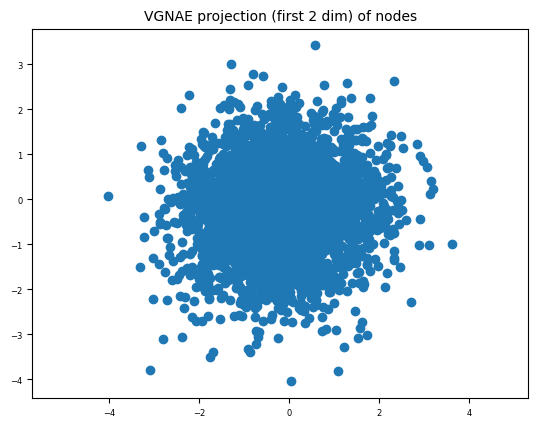

In [12]:
# plot embedding
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('VGNAE projection (first 2 dim) of nodes')

In [13]:
node_emb = pd.DataFrame(embedding).rename(columns = {val: f"x{val+1}" for val in range(embedding.shape[1])})

In [14]:
node_emb

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64
0,-0.063865,-0.730979,0.433307,0.024795,0.341493,1.126635,0.252332,0.544171,0.384873,0.436641,...,1.753121,1.401360,1.112463,0.342296,0.416504,0.519761,-0.610225,0.557281,-0.353902,2.165911
1,-0.719983,2.074478,-0.409308,-0.617679,1.720305,-0.018426,0.018287,0.762303,-1.207347,-0.114491,...,-0.954103,0.785100,-1.750763,0.509461,0.305428,-1.431960,-0.833624,1.195829,2.267903,-0.346768
2,-0.854924,0.544676,0.057756,-0.519429,-0.291038,-0.963310,0.077309,-0.812664,1.104375,0.760463,...,-1.467102,-0.814304,-1.277474,0.257432,0.724200,-0.125126,-1.996228,2.205127,1.779915,-0.872934
3,0.603146,-2.241166,1.049366,-0.307093,-0.045722,0.820539,0.229573,0.248375,-0.648733,-0.499698,...,-1.143108,-0.449587,0.521415,1.277544,-0.439586,-1.071920,-1.067441,-0.315623,0.575625,1.020827
4,-0.451971,1.093642,-0.716239,-0.314964,-0.853331,-0.827260,0.072287,1.483413,-0.090427,0.296355,...,1.570473,0.239540,-1.381986,-0.730668,-0.517656,-0.525959,1.064256,-1.042043,-0.299195,-0.302309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3592,-1.796760,-1.037315,1.122389,-1.623044,0.575687,-1.320894,-0.884036,0.419252,0.072174,0.251858,...,-0.916614,1.871103,0.742685,-0.459412,-2.185042,-0.388104,0.779588,1.789750,-0.644084,0.352651
3593,1.071986,-0.652288,-0.620980,-0.758068,0.861363,-1.143569,0.345614,0.017415,-0.247239,-0.250366,...,-0.578490,-1.262724,-1.770784,1.782915,1.388147,-0.377131,-0.319400,-2.115265,-0.942785,1.597077
3594,0.433297,-0.709473,0.471593,2.220093,0.582405,0.002625,-0.897635,0.774775,1.409454,2.721758,...,1.765854,-0.450325,-0.967829,-0.257652,-1.861384,-0.257584,-0.153752,-1.652323,-0.628629,-0.381228
3595,-1.667803,-1.268852,-0.239316,-0.640469,0.234211,0.612983,2.556522,-0.378770,0.166229,-0.260701,...,0.502788,-0.443144,1.522099,-0.313125,-1.537309,0.106097,-0.898324,0.045709,-1.562389,-0.549867


#### 3.4 Compute edge features based on best model

In [15]:
# predict train
y_train_hat = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.train_edges))
y_train_hat = (y_train_hat
    .rename(columns = {0: "sim"})
    .assign(y = trainval_tf.loc[trainval_tf.train_mask == True].y.values)
    .assign(pred = lambda df_: (df_.sim > df_.sim.median()).astype(int))
)
print("ROC: ", roc_auc_score(y_train_hat.y, y_train_hat.sim))
print("Acc: ", accuracy_score(y_train_hat.y, y_train_hat.pred))

ROC:  0.8449736372512249
Acc:  0.7424749163879598


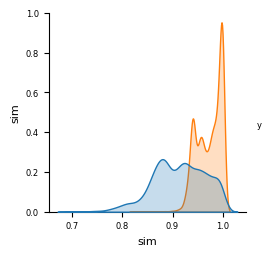

In [16]:
sns.pairplot(y_train_hat[["sim", "y"]], hue = "y")

In [33]:
# predict val
y_val_hat = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.val_edges))
y_val_hat = (y_val_hat
    .rename(columns = {0: "sim"})
    .assign(y = trainval_tf.loc[trainval_tf.val_mask == True].y.values)
    .assign(pred = lambda df_: (df_.sim > df_.sim.median()).astype(int))
)
print("ROC: ", roc_auc_score(y_val_hat.y, y_val_hat.sim))
print("Acc: ", accuracy_score(y_val_hat.y, y_val_hat.pred))

ROC:  0.7814185271424006
Acc:  0.7204968944099379


In [34]:
tmp = (val_tf
    .assign(sim  = y_val_hat.pred.values)
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.node1, df_.node2)])
)

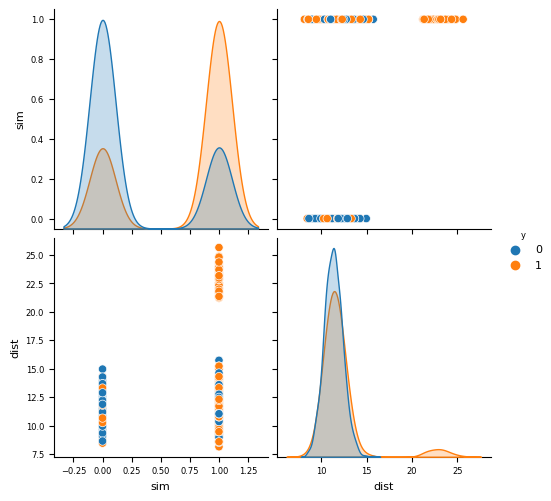

In [35]:
sns.pairplot(tmp[["sim", "dist", "y"]], hue = "y")

In [36]:
tmp.corr()

,node1,node2,y,sim,dist
node1,1.000000,0.493127,0.036595,0.258322,-0.043189
node2,0.493127,1.000000,0.059586,0.318567,-0.050833
y,0.036595,0.059586,1.000000,0.440995,0.171970
sim,0.258322,0.318567,0.440995,1.000000,0.178310
dist,-0.043189,-0.050833,0.171970,0.178310,1.000000


In [37]:
# predict test
y_test_hat = pd.DataFrame(autoenc.get_similarity(model, data.x, data.trainval_pos_edges, data.test_edges))
y_test_hat = (y_test_hat
    .rename(columns = {0: "sim"})
    .assign(pred = lambda df_: (df_.sim > df_.sim.median()).astype(int))
)
y_test_hat[["pred"]].value_counts()

pred
0       1741
1       1740
dtype: int64

### X. Code Graveyard

previous code without functions

In [16]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
channels = 2
model = VGAE(deep.Encoder(data.x.size()[1], channels)).to(dev)

In [17]:
x, train_pos_edges, train_neg_edges = data.x.to(dev), data.train_pos_edges.to(dev), data.train_neg_edges.to(dev)
val_pos_edges, val_neg_edges = data.val_pos_edges.to(dev), data.val_neg_edges.to(dev)
val_edges = data.val_edges.to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-6, weight_decay = 0.1)

In [20]:
def train():
    model.train()
    optimizer.zero_grad()
    z  = model.encode(x, train_pos_edges)
    loss = model.recon_loss(z, train_pos_edges, train_neg_edges)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    auc, ap = validate(data.train_pos_edges, data.train_neg_edges)
    return loss, auc, ap

def validate(val_pos_edges, val_neg_edges):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edges)
    return model.test(z, val_pos_edges, val_neg_edges)

def predict(edges):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edges)
    pred = model.decoder(z, edges, sigmoid = True)
    return pred.detach().cpu().numpy()

def get_embeddings():
    return model.encode(x, train_pos_edges).detach().cpu().numpy()

In [21]:
for epoch in range(1,50):
    loss, trn_auc, trn_ap = train()
    loss = float(loss)
    
    with torch.no_grad():
        auc, ap = validate(data.val_pos_edges, data.val_neg_edges)
        print('Epoch: {:03d}, LOSS: {:.4f}, Trn AUC: {:.4f}, Val AUC: {:.4f}, Val AP: {:.4f}'.format(epoch, loss, trn_auc, auc, ap))

Epoch: 001, LOSS: 3.9292, Trn AUC: 0.7867, Val AUC: 0.7420, Val AP: 0.7823
Epoch: 002, LOSS: 4.0428, Trn AUC: 0.7866, Val AUC: 0.7420, Val AP: 0.7822
Epoch: 003, LOSS: 3.9016, Trn AUC: 0.7866, Val AUC: 0.7419, Val AP: 0.7822
Epoch: 004, LOSS: 4.0921, Trn AUC: 0.7865, Val AUC: 0.7419, Val AP: 0.7821
Epoch: 005, LOSS: 4.0718, Trn AUC: 0.7865, Val AUC: 0.7418, Val AP: 0.7820
Epoch: 006, LOSS: 3.9491, Trn AUC: 0.7864, Val AUC: 0.7417, Val AP: 0.7819
Epoch: 007, LOSS: 3.9936, Trn AUC: 0.7864, Val AUC: 0.7417, Val AP: 0.7819
Epoch: 008, LOSS: 3.9383, Trn AUC: 0.7863, Val AUC: 0.7416, Val AP: 0.7818
Epoch: 009, LOSS: 4.0555, Trn AUC: 0.7863, Val AUC: 0.7415, Val AP: 0.7817
Epoch: 010, LOSS: 4.1547, Trn AUC: 0.7862, Val AUC: 0.7414, Val AP: 0.7817
Epoch: 011, LOSS: 3.9986, Trn AUC: 0.7862, Val AUC: 0.7413, Val AP: 0.7816
Epoch: 012, LOSS: 3.9577, Trn AUC: 0.7861, Val AUC: 0.7412, Val AP: 0.7815
Epoch: 013, LOSS: 3.9537, Trn AUC: 0.7860, Val AUC: 0.7412, Val AP: 0.7815
Epoch: 014, LOSS: 3.9163,

In [14]:
# predict train
train_edges = data.train_edges.to(dev)
y_train_hat = pd.DataFrame(predict(train_edges))
y_train_hat = (y_train_hat
    .rename(columns = {0: "pred"})
    .assign(y = trainval_tf.loc[trainval_tf.train_mask == True].y.values)
    .assign(bin_pred = lambda df_: (df_.pred > df_.pred.median()).astype(int))
)

NameError: name 'trainval_tf' is not defined

In [ ]:
from sklearn.metrics import average_precision_score, roc_auc_score
print("ROC: ", roc_auc_score(y_train_hat.y, y_train_hat.pred))
print("Acc: ", accuracy_score(y_train_hat.y, y_train_hat.bin_pred))

In [625]:
# predict val
val_edges = data.val_edges.to(dev)
y_val_hat = pd.DataFrame(predict(val_edges))
y_val_hat = (y_val_hat
    .rename(columns = {0: "pred"})
    .assign(y = trainval_tf.loc[trainval_tf.val_mask == True].y.values)
    .assign(bin_pred = lambda df_: (df_.pred > df_.pred.median()).astype(int))
)

In [626]:
from sklearn.metrics import average_precision_score, roc_auc_score
print("ROC: ", roc_auc_score(y_val_hat.y, y_val_hat.pred))
print("Acc: ", accuracy_score(y_val_hat.y, y_val_hat.bin_pred))

ROC:  0.7690234214491166
Acc:  0.7185857620640229


In [661]:
# predict test
test_edges = data.test_edges.to(dev)
y_test_hat = pd.DataFrame(predict(test_edges))
y_test_hat = (y_test_hat
    .rename(columns = {0: "pred"})
    .assign(bin_pred = lambda df_: (df_.pred > df_.pred.median()).astype(int))
)
y_test_hat[["bin_pred"]].value_counts()

bin_pred
0           1741
1           1740
dtype: int64

In [628]:
# get embeddings
embedding = get_embeddings()

Text(0.5, 1.0, 'UMAP projection (first 2 dim) of Node information')

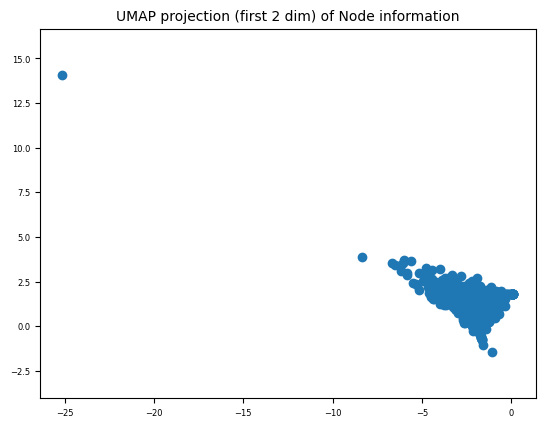

In [629]:
# plot umap embedding of nodes
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection (first 2 dim) of Node information')

same as above but using dataset from https://github.com/SeongJinAhn/VGNAE/blob/main/main.py to validate

In [19]:
from torch_geometric.utils import train_test_split_edges
from torch_geometric.datasets import Planetoid, Coauthor, Amazon
dataset = Planetoid("cora", "Cora", 'public')
data = dataset[0]
data = T.NormalizeFeatures()(data)

In [20]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
channels = 128
train_rate = 0.8
val_ratio = 0.2 / 3
test_ratio = 0.2 / 3 * 2
data = train_test_split_edges(data.to(dev), val_ratio=val_ratio, test_ratio=test_ratio)

C:\Users\lasse\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [21]:
model = VGAE(Encoder(data.x.size()[1], channels, data.train_pos_edge_index)).to(dev)

In [15]:
data.train_mask = data.val_mask = data.test_mask = data.y = None
x, train_pos_edge_index = data.x.to(dev), data.train_pos_edge_index.to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [16]:
def train():
    model.train()
    optimizer.zero_grad()
    z  = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss

def test(pos_edge_index, neg_edge_index, plot_his=0):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [17]:
for epoch in range(1,100):
    loss = train()
    loss = float(loss)
    
    with torch.no_grad():
        test_pos, test_neg = data.test_pos_edge_index, data.test_neg_edge_index
        auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
        print('Epoch: {:03d}, LOSS: {:.4f}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, loss, auc, ap))

Epoch: 001, LOSS: 10.5961, AUC: 0.6936, AP: 0.7234
Epoch: 002, LOSS: 10.3247, AUC: 0.6953, AP: 0.7248
Epoch: 003, LOSS: 10.2399, AUC: 0.6970, AP: 0.7261
Epoch: 004, LOSS: 9.8528, AUC: 0.6987, AP: 0.7274
Epoch: 005, LOSS: 9.8399, AUC: 0.7007, AP: 0.7289
Epoch: 006, LOSS: 9.4896, AUC: 0.7026, AP: 0.7303
Epoch: 007, LOSS: 9.3072, AUC: 0.7048, AP: 0.7319
Epoch: 008, LOSS: 9.2995, AUC: 0.7072, AP: 0.7337
Epoch: 009, LOSS: 8.8477, AUC: 0.7100, AP: 0.7358
Epoch: 010, LOSS: 9.0528, AUC: 0.7135, AP: 0.7383
Epoch: 011, LOSS: 8.7333, AUC: 0.7177, AP: 0.7414
Epoch: 012, LOSS: 8.5690, AUC: 0.7231, AP: 0.7454
Epoch: 013, LOSS: 8.3032, AUC: 0.7302, AP: 0.7509
Epoch: 014, LOSS: 8.1966, AUC: 0.7396, AP: 0.7583
Epoch: 015, LOSS: 8.0069, AUC: 0.7523, AP: 0.7680
Epoch: 016, LOSS: 7.8474, AUC: 0.7706, AP: 0.7826
Epoch: 017, LOSS: 7.6897, AUC: 0.7985, AP: 0.8053
Epoch: 018, LOSS: 7.4065, AUC: 0.8373, AP: 0.8390
Epoch: 019, LOSS: 7.1321, AUC: 0.8854, AP: 0.8849
Epoch: 020, LOSS: 6.6308, AUC: 0.9218, AP: 0.92